# Decision Tree and Ensemble Methods for Small Dataset

I decided to start trying to predict the ice/no ice condition in a single location, then we can extend it somehow to the full airfoil

First we check the properties of the dataset at hand:

In [29]:
# Import required packages
from __future__ import print_function
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor, export_graphviz, DecisionTreeClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier

import graphviz

    Temperture[K]  AoA[o]    Mach  MVD[mum]  rho[kg/m3]  0.617035028915481
0       249.83088 7.20324 0.30006   0.00002     0.52107                  1
1       236.84354 1.86260 0.47278   0.00003     0.84452                  0
2       249.91778 6.85220 0.40223   0.00005     0.42259                  1
3       259.96870 4.17305 0.57934   0.00002     0.56343                  0
4       265.17978 9.68262 0.45671   0.00004     1.12302                  1
5       268.93427 0.85044 0.31953   0.00002     1.12447                  0
6       237.08387 4.21108 0.77894   0.00003     0.97080                  0
7       245.77063 6.86501 0.71731   0.00001     1.01887                  0
8       272.70444 7.48166 0.44022   0.00004     0.48516                  1
9       251.06574 9.08596 0.44681   0.00002     0.50727                  1
10      233.92468 6.78836 0.40581   0.00002     0.80555                  1
11      235.28450 5.74118 0.37336   0.00003     0.97730                  1
12      237.24338 4.14056

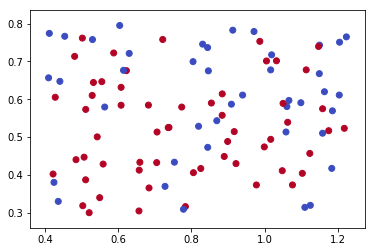

In [30]:
## UNDERSTANDING THE DATASET ##

# Setup pandas options
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:.5f}'.format

# Get the data
PT_data = pd.read_excel("../../Data/PTResults_trimmed.xlsx")

print(PT_data)

plt.scatter(
    PT_data['rho[kg/m3]'], PT_data['Mach'],
    cmap="coolwarm",
    c=PT_data[0.617035028915481]
)

plt.show()

The "0.617035028915481" is just the value of the abscissa for which I'm doing the ice formation prediction. It goes from 0 to 1. We can see from the scatter plot that the data doesn't seem to follow any pattern...you can try with any 2 features and you'll see the same.

We check now for correlations in the data.

In [31]:
# Correlation in the data
print(PT_data.corr()) # In this abscissa there is correlation with the AoA

                   Temperture[K]   AoA[o]     Mach  MVD[mum]  rho[kg/m3]  \
Temperture[K]            1.00000  0.01392  0.08578  -0.00323    -0.04582   
AoA[o]                   0.01392  1.00000 -0.03209  -0.04491    -0.23167   
Mach                     0.08578 -0.03209  1.00000   0.11292     0.06428   
MVD[mum]                -0.00323 -0.04491  0.11292   1.00000     0.00756   
rho[kg/m3]              -0.04582 -0.23167  0.06428   0.00756     1.00000   
0.617035028915481        0.06188  0.70264 -0.28541   0.27280    -0.17986   

                   0.617035028915481  
Temperture[K]                0.06188  
AoA[o]                       0.70264  
Mach                        -0.28541  
MVD[mum]                     0.27280  
rho[kg/m3]                  -0.17986  
0.617035028915481            1.00000  


Ice formation in this location is dominated by the angle of attack with a 0.7 correlation level.

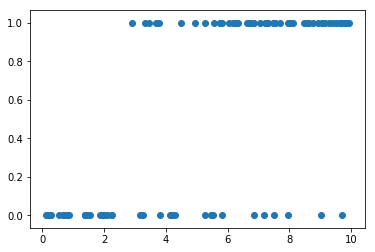

In [32]:
# Plotting the correlated features
plt.scatter(PT_data['AoA[o]'], PT_data[0.617035028915481])
plt.show()

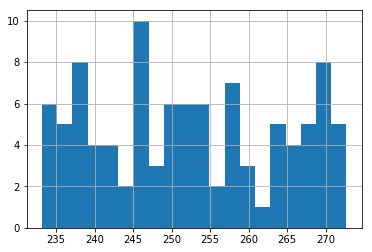

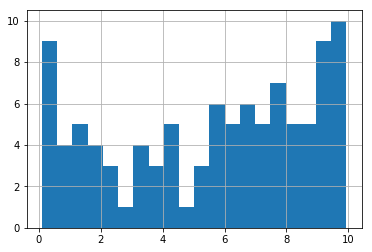

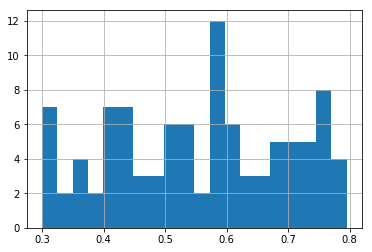

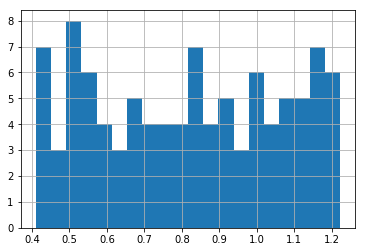

In [33]:
# Check that the data is evenly distributed so that MC was performed well
PT_data['Temperture[K]'].hist(bins=20)
plt.show()
PT_data['AoA[o]'].hist(bins=20)
plt.show()
PT_data['Mach'].hist(bins=20)
plt.show()
PT_data['rho[kg/m3]'].hist(bins=20)
plt.show()

Now we will train a Decision Tree Classifier to give us the ice/no ice condition on this portion of the airfoil under different conditions

In [34]:
## TRAINING THE DECISION TREE ##

target = 0.617035028915481
X = PT_data.drop(target, axis=1) # Just preparing the data
y = PT_data[target]

#Splitting the data into training and testing
training_features, testing_features, training_target, testing_target = train_test_split(
    X, y, test_size=0.15, shuffle=True)
print(training_features.describe())

       Temperture[K]   AoA[o]     Mach  MVD[mum]  rho[kg/m3]
count       85.00000 85.00000 85.00000  85.00000    85.00000
mean       251.59456  5.46456  0.55481   0.00003     0.82612
std         11.50228  3.14529  0.13762   0.00001     0.23868
min        233.16608  0.10364  0.30006   0.00001     0.42259
25%        242.46897  2.90097  0.43332   0.00002     0.60820
50%        249.91778  5.81577  0.57304   0.00003     0.84452
75%        259.96870  8.12611  0.67493   0.00004     1.03212
max        271.15704  9.93913  0.79488   0.00005     1.22279


This is just the training set features. The shuffle=True is important in case that the data is ordered in some specific way. Shuffling makes the testing and training datasets be distributed in the same way so that it makes sense to train with that portion of the data.

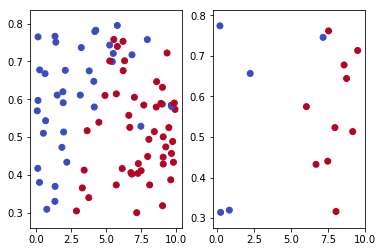

In [35]:
# Comparing distributions of training and testing datasets
fig, axes = plt.subplots(1,2)
axes[0].scatter(
    training_features['AoA[o]'], training_features['Mach'],
    cmap="coolwarm",
    c=training_target
)
axes[1].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target
)
plt.show()

One could say that they both follow the same pattern...

In [36]:
#Training the DT
model = DecisionTreeClassifier(max_depth=10)
model.fit(training_features, training_target)

#Comparing prediction with testing values
prediction = model.predict(testing_features)
print('Prediction:', prediction)
print('Testing   :', np.array(testing_target))
print(mean_squared_error(prediction, testing_target))
print(int(15*mean_squared_error(prediction, testing_target)))

Prediction: [0 1 0 1 0 0 1 1 1 0 0 1 1 1 1]
Testing   : [1 1 0 1 0 0 1 1 0 1 0 1 1 1 1]
0.2
3


Comparing the testing solutions to the predicted ones in a scatter colour plot.

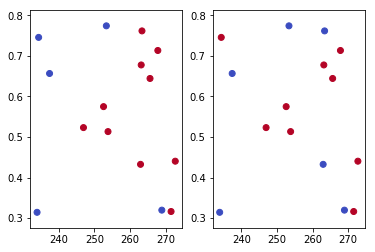

In [37]:
# Comparing distributions of prediction and testing dataset
fig, axes = plt.subplots(1,2)
axes[0].scatter(
    testing_features['Temperture[K]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target
)
axes[1].scatter(
    testing_features['Temperture[K]'], testing_features['Mach'],
    cmap="coolwarm",
    c=prediction
)
plt.show()

The mean squared error tells us how many times the Decision Tree got it wrong (check the last number). The following snippet is to be able to visualize the random tree created but I just get errors. You can try.

In [38]:
#dot_data = export_graphviz(
#    model, out_file=None, feature_names=list(training_features), filled=True, 
#    rounded=True, special_characters=True)
#graph = graphviz.Source(dot_data)
#graph.render("Ice formation") 
#graph 

# converting into the pdf file
#with open("model.dot", "w") as f:
#    f = export_graphviz(model, out_file=f)
    
#dot -Tpdf fruit_classifier.dot -o fruit_classifier.pdf

Next, I tried different ensemble methods that suposedly improved the prediction of a single tree. Here you have Bagging, Random Forest, Extemely Randomized Tree (WTF) and Boosting. But first, I did 1000 times the procedure before to have a distribution on the error gotten with the decision tree when using different groups of the data for testing and training.

In [39]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=0.15, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)

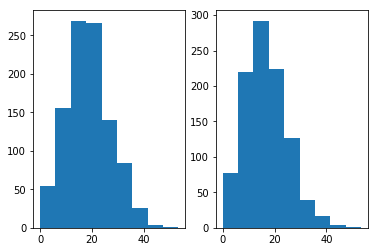

In [40]:
MSE_vector_3=[]
MSE_vector_10=[]
ncells_missclass_3=[]
ncells_missclass_10=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Decision Tree
    model_3 = DecisionTreeClassifier(max_depth=3)
    model_3.fit(training_features, training_target)
    model_10 = DecisionTreeClassifier(max_depth=10)
    model_10.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction_3 = model_3.predict(testing_features)
    prediction_10 = model_10.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE_3 = mean_squared_error(prediction_3, testing_target)
    MSE_10 = mean_squared_error(prediction_10, testing_target)
    MSE_vector_3.append(MSE_3)
    MSE_vector_10.append(MSE_10)
    ncells_missclass_3.append(15*mean_squared_error(prediction_3, testing_target))
    ncells_missclass_10.append(15*mean_squared_error(prediction_10, testing_target)) 
    
#plt.hist(MSE_vector, bins=10)
#plt.hist(ncells_missclass_3, bins=12)
#plt.show()

ncells_missclass_3=np.array(ncells_missclass_3)/15*100
ncells_missclass_10=np.array(ncells_missclass_10)/15*100

# Comparing distributions for depth 3 and 10
fig, axes = plt.subplots(1,2)
axes[0].hist(ncells_missclass_3, bins=9)
axes[1].hist(ncells_missclass_10, bins=9)
plt.show()

Technically, we should find the tree with the best accuracy. This is enough if the distribution of the training set and test set are the same. Then that's the best we can do with decision trees or any other ensemble methods. Let's try with decision trees and one location then we extend.

    Temperture[K]  AoA[o]    Mach  MVD[mum]  rho[kg/m3]
1       236.84354 1.86260 0.47278   0.00003     0.84452
30      236.02897 9.67276 0.58405   0.00002     0.60817
91      262.42202 9.09293 0.50044   0.00002     0.54308
72      245.15993 1.43006 0.75065   0.00003     1.20416
67      234.04322 3.24362 0.73646   0.00004     0.84421
41      252.58963 6.04310 0.57477   0.00005     1.15796
82      237.51075 6.33787 0.70148   0.00004     1.03212
55      260.26204 1.98570 0.51335   0.00002     1.05805
96      246.18959 8.59489 0.57926   0.00004     0.77360
62      269.80222 9.09636 0.42856   0.00001     0.55919
70      263.95955 7.31729 0.42985   0.00002     0.92165
71      246.96190 7.96589 0.52307   0.00004     1.21714
45      270.75430 5.82014 0.73942   0.00004     1.14695
15      239.76417 9.27509 0.47388   0.00004     0.99895
4       265.17978 9.68262 0.45671   0.00004     1.12302


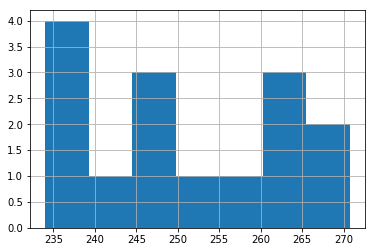

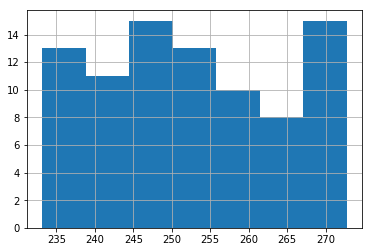

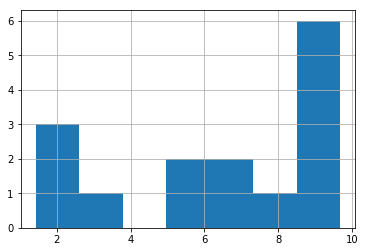

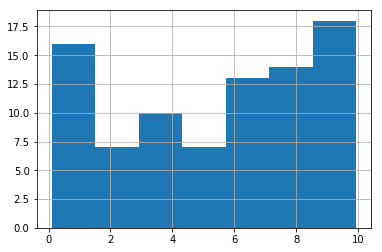

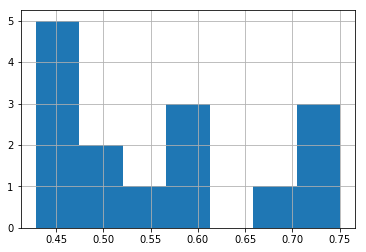

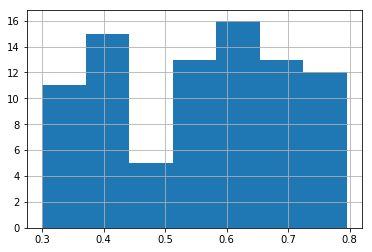

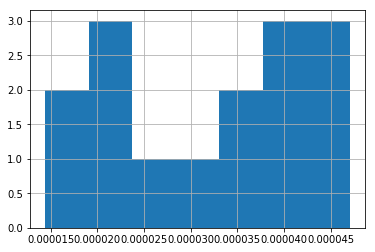

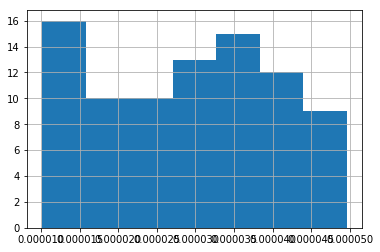

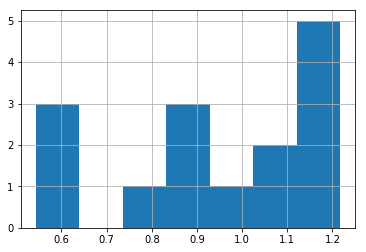

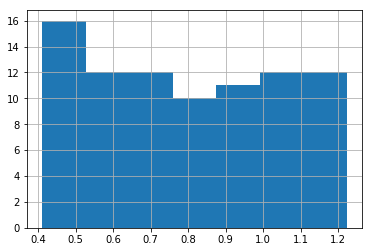

In [45]:
print(testing_features)

# Check that the data is i.i.d training vs testing
testing_features['Temperture[K]'].hist(bins=7)
plt.show()
training_features['Temperture[K]'].hist(bins=7)
plt.show()

testing_features['AoA[o]'].hist(bins=7)
plt.show()
training_features['AoA[o]'].hist(bins=7)
plt.show()

testing_features['Mach'].hist(bins=7)
plt.show()
training_features['Mach'].hist(bins=7)
plt.show()

testing_features['MVD[mum]'].hist(bins=7)
plt.show()
training_features['MVD[mum]'].hist(bins=7)
plt.show()

testing_features['rho[kg/m3]'].hist(bins=7)
plt.show()
training_features['rho[kg/m3]'].hist(bins=7)
plt.show()


Next, I did the same for Extra Trees and the other ensemble methods.

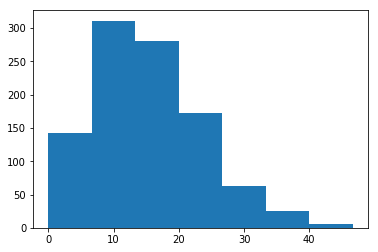

In [46]:
#Extra Tree

MSE_vector=[]
ncells_missclass=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    randomized_trees = ExtraTreesClassifier(max_depth=10)
    randomized_trees.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = randomized_trees.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(15*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)
ncells_missclass=np.array(ncells_missclass)/15*100
plt.hist(ncells_missclass, bins=7)
plt.show()

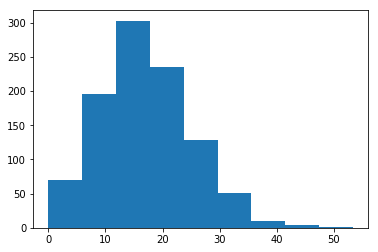

In [47]:
#Bagging

MSE_vector=[]
ncells_missclass=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    bagging=BaggingClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=100, max_samples=0.5, max_features=0.5
    )
    bagging.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = bagging.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(15*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)
ncells_missclass=np.array(ncells_missclass)/15*100
plt.hist(ncells_missclass, bins=9)
plt.show()

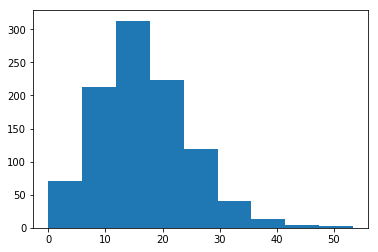

In [48]:
#Boosting

MSE_vector=[]
ncells_missclass=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    boosted = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10), n_estimators=10)
    boosted.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = boosted.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(15*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)

ncells_missclass=np.array(ncells_missclass)/15*100
plt.hist(ncells_missclass, bins=9)
plt.show()

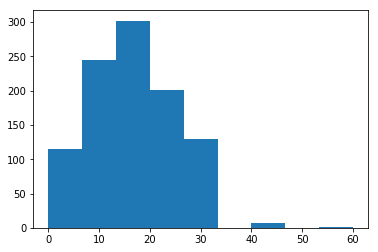

In [49]:
#Random Forest

MSE_vector=[]
ncells_missclass=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    random_forest = RandomForestClassifier(max_depth=10)
    random_forest.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = random_forest.predict(testing_features)
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(15*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)

ncells_missclass=np.array(ncells_missclass)/15*100
plt.hist(ncells_missclass, bins=9)
plt.show()

In [50]:
## ENSEMBLE METHODS ##

#Bagging
bagging = BaggingClassifier(
    DecisionTreeClassifier(max_depth=10),
    n_estimators=100, max_samples=0.5, max_features=0.5
)
bagging.fit(training_features, training_target)
bagging_prediction = bagging.predict(testing_features)
print('Bagging MSE:', mean_squared_error(bagging_prediction, testing_target))

#Random Forest
random_forest = RandomForestClassifier(max_depth=10)
random_forest.fit(training_features, training_target)
rf_prediction = random_forest.predict(testing_features)
print('RF MSE:', mean_squared_error(rf_prediction, testing_target))

#Extremely Randomized Tree
randomized_trees = ExtraTreesClassifier(max_depth=10)
randomized_trees.fit(training_features, training_target)
rt_prediction = randomized_trees.predict(testing_features)
print('ERT MSE:', mean_squared_error(rt_prediction, testing_target))

#Boosting
boosted = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10), n_estimators=10)
boosted.fit(training_features, training_target)
boosted_prediction = boosted.predict(testing_features)
print('Boosting:', mean_squared_error(boosted_prediction, testing_target))

Bagging MSE: 0.0
RF MSE: 0.06666666666666667
ERT MSE: 0.0
Boosting: 0.0


Plotting the MSE for each of the four ensemble methods above versus the maximum depth used (from 2 to 20).

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


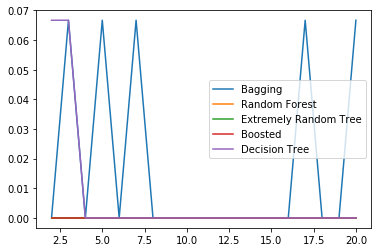

In [51]:
def test_error(model):
    model.fit(training_features, training_target)
    prediction = model.predict(testing_features)
    return mean_squared_error(prediction, testing_target)


min_depth = 2
max_depth = 20

estimators = 100

mse = np.zeros((max_depth - min_depth + 1, 5))
for i, D in enumerate(range(2, max_depth + 1)):
    print(D)
    model = BaggingClassifier(
        DecisionTreeClassifier(max_depth=D),
        n_estimators=estimators, max_samples=0.5, max_features=0.5
    )
    mse[i, 0] = test_error(model)

    model = RandomForestClassifier(max_depth=D, n_estimators=estimators)
    mse[i, 1] = test_error(model)

    model = ExtraTreesClassifier(max_depth=D, n_estimators=estimators)
    mse[i, 2] = test_error(model)

    model = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=D), n_estimators=estimators)
    mse[i, 3] = test_error(model)
    
    model = DecisionTreeClassifier(max_depth=D)
    mse[i, 4] = test_error(model)


plt.plot(range(min_depth, max_depth+1), mse[:,0])
plt.plot(range(min_depth, max_depth+1), mse[:,1])
plt.plot(range(min_depth, max_depth+1), mse[:,2])
plt.plot(range(min_depth, max_depth+1), mse[:,3])
plt.plot(range(min_depth, max_depth+1), mse[:,4])
plt.legend(['Bagging', 'Random Forest', 'Extremely Random Tree', 'Boosted', 'Decision Tree'])
plt.show()

It seems that the Extremely Randomized Tree performs better overall. It looks quite discreet because everytime there is an error is a jump of value one...

The previous chunk of notebook was devoted to the classification for ice/no ice condition on a single location on an airfoil. Now, we are going to attempt the prediction of ice formation for different conditions on all parts of the airfoil.

# All airfoil locations small data 100 samples

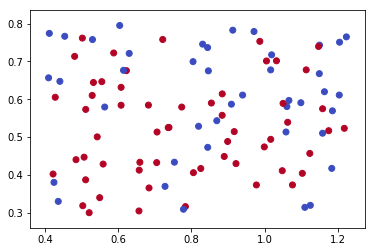

In [52]:
## UNDERSTANDING THE DATASET ##

# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

# Get the data
PT_data = pd.read_excel("../../Data/PTResults_ice.xlsx")

plt.scatter(
    PT_data['rho[kg/m3]'], PT_data['Mach'],
    cmap="coolwarm",
    c=PT_data[0.617035028915481]
)

plt.show()

In [53]:
# Correlation in the data
#print(PT_data.corr())

In [54]:
## TRAINING THE DECISION TREE ##

#target = [0,0.00847867126218693,0.609477617930035,0.617035028915481,0.636371419678129,0.936541946531039]
target=PT_data.iloc[:,6:128]
X = PT_data.drop(target, axis=1) # Just preparing the data
y = target

#Splitting the data into training and testing
training_features, testing_features, training_target, testing_target = train_test_split(
    X, y, test_size=0.15, shuffle=True)

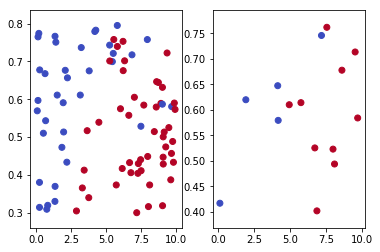

In [55]:
# Comparing distributions of training and testing datasets on a given location
fig, axes = plt.subplots(1,2)
axes[0].scatter(
    training_features['AoA[o]'], training_features['Mach'],
    cmap="coolwarm",
    c=training_target[0.617035028915481]
)
axes[1].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target[0.617035028915481]
)
plt.show()

In [56]:
#Training the DT
model = DecisionTreeClassifier(max_depth=10)
model.fit(training_features, training_target)

#Comparing prediction with testing values
prediction = model.predict(testing_features)
#print('Prediction:', prediction)
#print('Testing   :', np.array(testing_target))

lst_pred = [item[92] for item in prediction]
lst_test = [item[92] for item in np.array(testing_target)]

print('Prediction:', lst_pred)
print('Testing   :', lst_test)

print(mean_squared_error(lst_pred, lst_test))
print(int(15*mean_squared_error(lst_pred, lst_test)))

Prediction: [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
Testing   : [1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1]
0.06666666666666667
1


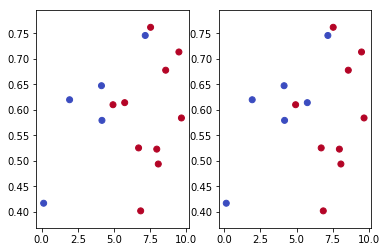

In [57]:
# Comparing distributions of training and testing datasets

#Getting first/second/third... whatever component of the vectors
#making up a list of vectors such as in the prediction list
lst2 = [item[92] for item in prediction]

fig, axes = plt.subplots(1,2)
axes[0].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=testing_target[0.617035028915481]
)
axes[1].scatter(
    testing_features['AoA[o]'], testing_features['Mach'],
    cmap="coolwarm",
    c=lst2
)
plt.show()

We repeat the process 1000 times and compute the distributions per location.

In [58]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=0.15, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)

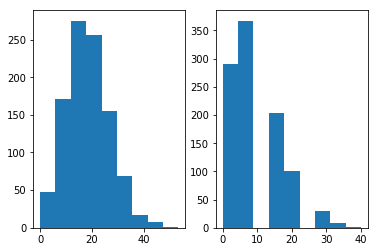

In [59]:
MSE_vector_3=[]
MSE_vector_10=[]
ncells_missclass_3=[]
ncells_missclass_10=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Decision Tree
    model_3 = DecisionTreeClassifier(max_depth=3)
    model_3.fit(training_features, training_target)
    model_10 = DecisionTreeClassifier(max_depth=10)
    model_10.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction_3 = model_3.predict(testing_features)
    prediction_10 = model_10.predict(testing_features)
    lst3 = [item[92] for item in prediction_3]
    lst10 = [item[92] for item in prediction_10]
    
    testing_target=np.array(testing_target)
    lst3t = [item[92] for item in testing_target]
    
    #MSE and number of missclassified cells distributions
    MSE_3 = mean_squared_error(lst3, lst3t)
    MSE_10 = mean_squared_error(lst10, lst3t)
    MSE_vector_3.append(MSE_3)
    MSE_vector_10.append(MSE_10)
    ncells_missclass_3.append(15*mean_squared_error(lst3, lst3t))
    ncells_missclass_10.append(15*mean_squared_error(lst10, lst3t)) 
    
#plt.hist(MSE_vector, bins=10)
#plt.hist(ncells_missclass_3, bins=12)
#plt.show()

ncells_missclass_3=np.array(ncells_missclass_3)/15*100
ncells_missclass_10=np.array(ncells_missclass_10)/15*100

# Comparing distributions for depth 3 and 10
fig, axes = plt.subplots(1,2)
axes[0].hist(ncells_missclass_3, bins=9)
axes[1].hist(ncells_missclass_10, bins=9)
plt.show()

Computing the error in all airfoil for a given condition.

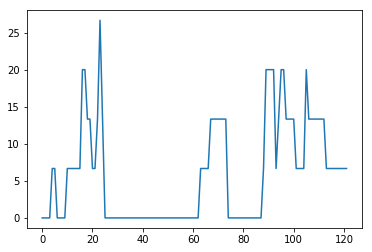

In [105]:
#Training with Decision Tree
model_3 = DecisionTreeClassifier(max_depth=3)
model_3.fit(training_features, training_target)
model_10 = DecisionTreeClassifier(max_depth=10)
model_10.fit(training_features, training_target)

#Comparing prediction with testing values
prediction_3 = model_3.predict(testing_features)
prediction_10 = model_10.predict(testing_features)
    
testing_target=np.array(testing_target)
    
#Number of missclassified cells for each conditions on the airfoil
n_missclass_airfoil = []
abscissa = []

for i in range(122):
    
    lst_pred = [item[i] for item in prediction_3]
    lst_test = [item[i] for item in np.array(testing_target)]
    
    n_missclass_airfoil.append(int(15*mean_squared_error(lst_pred,lst_test)))
    abscissa.append(i)

n_missclass_airfoil = np.array(n_missclass_airfoil)/15*100

# Comparing distributions for depth 3 and 10

plt.plot(abscissa,n_missclass_airfoil)
plt.show()

#ncells_missclass_3.append(15*mean_squared_error(lst3, lst3t))
#ncells_missclass_10.append(15*mean_squared_error(lst10, lst3t)) 

#ncells_missclass_3=np.array(ncells_missclass_3)/15*100
#ncells_missclass_10=np.array(ncells_missclass_10)/15*100

# Comparing distributions for depth 3 and 10
#fig, axes = plt.subplots(1,2)
#axes[0].hist(ncells_missclass_3, bins=9)
#axes[1].hist(ncells_missclass_10, bins=9)
#plt.show()

# Big data problem: 1000 samples

From now on, I'll focus on the big data problem, I will use the previous stuff as examples of scripts.

In [110]:
# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

# Get the data
PT_data_1000 = pd.read_excel("../../Data/PTResults-1000_ice.xlsx")

In [111]:
## TRAINING THE DECISION TREE ##

target=PT_data_1000.iloc[:,6:128]
X = PT_data_1000.drop(target, axis=1) # Just preparing the data
y = target

#Splitting the data into training and testing
training_features, testing_features, training_target, testing_target = train_test_split(
    X, y, test_size=0.15, shuffle=True)

#Training the DT
model = DecisionTreeClassifier(max_depth=10)
model.fit(training_features, training_target)

#Comparing prediction with testing values
prediction = model.predict(testing_features)

lst_pred = [item[92] for item in prediction]
lst_test = [item[92] for item in np.array(testing_target)]
    
print(mean_squared_error(lst_pred, lst_test))
print(int(150*mean_squared_error(lst_pred, lst_test)))

0.06666666666666667
10


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
0


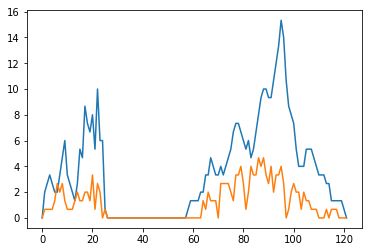

In [120]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=0.15, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)

minimum_3 = []
minimum_10 = []

for j in range(122):
    
    MSE_vector_3=[]
    MSE_vector_10=[]
    ncells_missclass_3=[]
    ncells_missclass_10=[]
    shuffle = 0
    
    print(j)
    
    for i in range(10):
        training_features = training_features_vector[i]
        testing_features = testing_features_vector[i]
        training_target = training_target_vector[i]
        testing_target = testing_target_vector[i]

        #Training with Decision Tree
        model_3 = DecisionTreeClassifier(max_depth=3)
        model_3.fit(training_features, training_target)
        model_10 = DecisionTreeClassifier(max_depth=10)
        model_10.fit(training_features, training_target)

        #Comparing prediction with testing values
        prediction_3 = model_3.predict(testing_features)
        prediction_10 = model_10.predict(testing_features)
        lst3 = [item[j] for item in prediction_3]
        lst10 = [item[j] for item in prediction_10]
    
        testing_target=np.array(testing_target)
        lst3t = [item[j] for item in testing_target]
    
        #MSE and number of missclassified cells distributions
        MSE_3 = mean_squared_error(lst3, lst3t)
        MSE_10 = mean_squared_error(lst10, lst3t)
        MSE_vector_3.append(MSE_3)
        MSE_vector_10.append(MSE_10)
        ncells_missclass_3.append(150*mean_squared_error(lst3, lst3t))
        ncells_missclass_10.append(150*mean_squared_error(lst10, lst3t)) 

        #ncells_missclass_3=np.array(ncells_missclass_3)/150*100
        #ncells_missclass_10=np.array(ncells_missclass_10)/150*100

    minimum_3.append(min(ncells_missclass_3))
    minimum_10.append(min(ncells_missclass_10))
    shuffle=np.argmin(ncells_missclass_10)

minimum_3=np.array(minimum_3)/150*100
minimum_10=np.array(minimum_10)/150*100    
print(shuffle)    
# Comparing distributions for depth 3 and 10

plt.plot(abscissa, minimum_3)
plt.plot(abscissa, minimum_10)
plt.show()

#fig, axes = plt.subplots(1,2)
#axes[0].hist(ncells_missclass_3, bins=9)
#axes[1].hist(ncells_missclass_10, bins=9)
#plt.show()

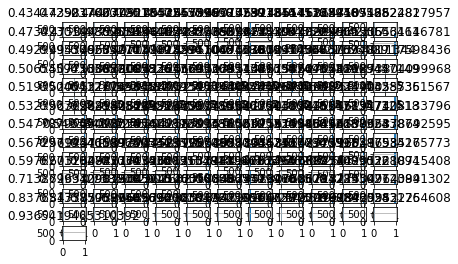

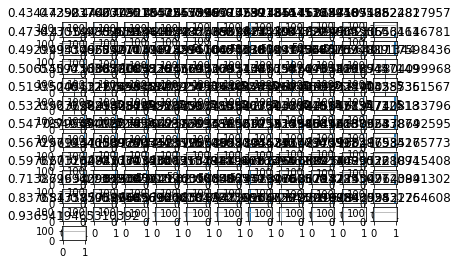

In [121]:
# Check that the data is evenly distributed so that MC was performed well

training_target = training_target_vector[0]
testing_target = testing_target_vector[0]

training_target.hist(bins=20)
plt.show()
testing_target.hist(bins=20)
plt.show()

In [ ]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=0.15, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)
    
    
MSE_vector_3=[]
MSE_vector_10=[]
ncells_missclass_3=[]
ncells_missclass_10=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Decision Tree
    model_3 = DecisionTreeClassifier(max_depth=3)
    model_3.fit(training_features, training_target)
    model_10 = DecisionTreeClassifier(max_depth=10)
    model_10.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction_3 = model_3.predict(testing_features)
    prediction_10 = model_10.predict(testing_features)
    lst3 = [item[92] for item in prediction_3]
    lst10 = [item[92] for item in prediction_10]
    
    testing_target=np.array(testing_target)
    lst3t = [item[92] for item in testing_target]
    
    #MSE and number of missclassified cells distributions
    MSE_3 = mean_squared_error(lst3, lst3t)
    MSE_10 = mean_squared_error(lst10, lst3t)
    MSE_vector_3.append(MSE_3)
    MSE_vector_10.append(MSE_10)
    ncells_missclass_3.append(150*mean_squared_error(lst3, lst3t))
    ncells_missclass_10.append(150*mean_squared_error(lst10, lst3t)) 

ncells_missclass_3=np.array(ncells_missclass_3)/150*100
ncells_missclass_10=np.array(ncells_missclass_10)/150*100

# Comparing distributions for depth 3 and 10
fig, axes = plt.subplots(1,2)
axes[0].hist(ncells_missclass_3, bins=9)
axes[1].hist(ncells_missclass_10, bins=9)
plt.show()

In [ ]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=0.15, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)
    
    
MSE_vector_3=[]
MSE_vector_10=[]
ncells_missclass_3=[]
ncells_missclass_10=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Decision Tree
    model_3 = DecisionTreeClassifier(max_depth=3)
    model_3.fit(training_features, training_target)
    model_10 = DecisionTreeClassifier(max_depth=10)
    model_10.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction_3 = model_3.predict(testing_features)
    prediction_10 = model_10.predict(testing_features)
    lst3 = [item[92] for item in prediction_3]
    lst10 = [item[92] for item in prediction_10]
    
    testing_target=np.array(testing_target)
    lst3t = [item[92] for item in testing_target]
    
    #MSE and number of missclassified cells distributions
    MSE_3 = mean_squared_error(lst3, lst3t)
    MSE_10 = mean_squared_error(lst10, lst3t)
    MSE_vector_3.append(MSE_3)
    MSE_vector_10.append(MSE_10)
    ncells_missclass_3.append(150*mean_squared_error(lst3, lst3t))
    ncells_missclass_10.append(150*mean_squared_error(lst10, lst3t)) 
    
#plt.hist(MSE_vector, bins=10)
#plt.hist(ncells_missclass_3, bins=12)
#plt.show()

ncells_missclass_3=np.array(ncells_missclass_3)/150*100
ncells_missclass_10=np.array(ncells_missclass_10)/150*100

# Comparing distributions for depth 3 and 10
fig, axes = plt.subplots(1,2)
axes[0].hist(ncells_missclass_3, bins=9)
axes[1].hist(ncells_missclass_10, bins=9)
plt.show()

In [ ]:
#Extra Tree

MSE_vector=[]
ncells_missclass=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Extra Trees
    randomized_trees = ExtraTreesClassifier(max_depth=10)
    randomized_trees.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction = randomized_trees.predict(testing_features)
    lst3t = [item[92] for item in testing_target]
    
    #MSE and number of missclassified cells distributions
    MSE = mean_squared_error(prediction, testing_target)
    MSE_vector.append(MSE)
    ncells_missclass.append(15*mean_squared_error(prediction, testing_target))
    
#plt.hist(MSE_vector, bins=10)
ncells_missclass=np.array(ncells_missclass)/15*100
plt.hist(ncells_missclass, bins=7)
plt.show()

# Data with collection efficiency

In [46]:
# Setup pandas options
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format

# Get the data
PT_data_1000 = pd.read_excel("../../Data/Data_Colleff_Entire_ice.xlsx")

#plt.scatter(
#    PT_data_1000['rho[kg/m3]'], PT_data_1000['Mach'],
#    cmap="coolwarm",
#    c=PT_data_1000[0.617035028915481]
#)

#plt.show()

In [47]:
## TRAINING THE DECISION TREE ##

#target = [0,0.00847867126218693,0.609477617930035,0.617035028915481,0.636371419678129,0.936541946531039]
target=PT_data_1000.iloc[:,6:128]
X = PT_data_1000.drop(target, axis=1) # Just preparing the data
y = target

#Splitting the data into training and testing
training_features, testing_features, training_target, testing_target = train_test_split(
    X, y, test_size=0.15, shuffle=True)

#Training the DT
model = DecisionTreeRegressor(max_depth=10)
model.fit(training_features, training_target)

#Comparing prediction with testing values
prediction = model.predict(testing_features)
#print('Prediction:', prediction)
#print('Testing   :', np.array(testing_target))

lst_pred = [item[92] for item in prediction]
lst_test = [item[92] for item in np.array(testing_target)]
lst_ice = []
lst_ice_test = []

for item in lst_pred:
    if item > 0.0:
        lst_ice.append(1)
    else:
        lst_ice.append(0)

for item in lst_test:
    if item > 0.0:
        lst_ice_test.append(1)
    else:
        lst_ice_test.append(0) 
        
print('Prediction:', lst_ice[100:120])
#print('Prediction:', lst_pred[10:20])
print('Testing   :', lst_ice_test[100:120])
    
#print(mean_squared_error(lst_pred, lst_test))
print(int(20*mean_squared_error(lst_ice[100:120], lst_ice_test[100:120])))

Prediction: [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0]
Testing   : [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0]
2


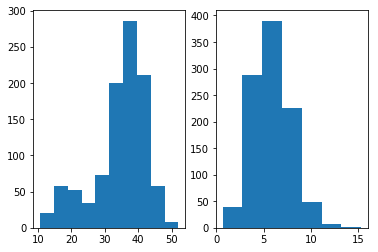

In [48]:
training_features_vector = []
testing_features_vector = []
training_target_vector = []
testing_target_vector = []

for i in range(1000):
    
    training_features, testing_features, training_target, testing_target = train_test_split(
        X, y, test_size=0.15, shuffle=True)
    #store
    training_features_vector.append(training_features)
    testing_features_vector.append(testing_features)
    training_target_vector.append(training_target)
    testing_target_vector.append(testing_target)
    
    
MSE_vector_3=[]
MSE_vector_10=[]
ncells_missclass_3=[]
ncells_missclass_10=[]

for i in range(1000):
    training_features = training_features_vector[i]
    testing_features = testing_features_vector[i]
    training_target = training_target_vector[i]
    testing_target = testing_target_vector[i]

    #Training with Decision Tree
    model_3 = DecisionTreeRegressor(max_depth=3)
    model_3.fit(training_features, training_target)
    model_10 = DecisionTreeRegressor(max_depth=10)
    model_10.fit(training_features, training_target)

    #Comparing prediction with testing values
    prediction_3 = model_3.predict(testing_features)
    prediction_10 = model_10.predict(testing_features)
    lst3 = [item[92] for item in prediction_3]
    lst10 = [item[92] for item in prediction_10]
    
    testing_target=np.array(testing_target)
    lst3t = [item[92] for item in testing_target]
    
    lst_ice3 = []
    lst_ice10 = []
    lst_ice_test3 = []
    
    for item in lst3:
        if item > 0.0:
            lst_ice3.append(1)
        else:
            lst_ice3.append(0)
        
    for item in lst10:
        if item > 0.0:
            lst_ice10.append(1)
        else:
            lst_ice10.append(0)
        
    for item in lst3t:
        if item > 0.0:
            lst_ice_test3.append(1)
        else:
            lst_ice_test3.append(0)
    
    #MSE and number of missclassified cells distributions
    MSE_3 = mean_squared_error(lst3, lst3t)
    MSE_10 = mean_squared_error(lst10, lst3t)
    MSE_vector_3.append(MSE_3)
    MSE_vector_10.append(MSE_10)
    ncells_missclass_3.append(150*mean_squared_error(lst_ice3, lst_ice_test3))
    ncells_missclass_10.append(150*mean_squared_error(lst_ice10, lst_ice_test3)) 
    
#plt.hist(MSE_vector, bins=10)
#plt.hist(ncells_missclass_3, bins=12)
#plt.show()

ncells_missclass_3=np.array(ncells_missclass_3)/150*100
ncells_missclass_10=np.array(ncells_missclass_10)/150*100

# Comparing distributions for depth 3 and 10
fig, axes = plt.subplots(1,2)
axes[0].hist(ncells_missclass_3, bins=10)
axes[1].hist(ncells_missclass_10, bins=7)
plt.show()